<p>
    <img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;">
    <h1 style="color:#1A5276;padding-left:115px;padding-bottom:0px;font-size:28px;">AWS IoT Analytics | Detecting Contextual Anomalies</h1>
</p>
<p style="color:#1A5276;padding-left:90px;padding-top:0px;position:relative;font-style:italic;font-size:18px">
Contextual anomaly detection in measured wind speed with a PEWMA model for Time Series data </p>

Detecting anomalies in data from IoT devices and processes is key to identifying instrumentation faults, failing devices, operational procedure errors and problematic noisy data that requires preprocessing to remove outliers. One of the challenges with IoT data is understanding what data constitutes an anomaly. There are obvious anomalies, such as when a temperature sensor reboots and registers first its maximum and then a 0 temperature before returning to normal data measurement. However, anomalies that are within the normal operating range of the system, but are outside of the normal operating range when compared to the surrounding measurements, are more difficult to discover.  These are called 'contextual' anomalies and are the target of this Notebook's time series anomaly detection.     

The sample data set in this Notebook is a time series wind speed measurement taken by a fleet of wind monitoring sensors throughout the city of San Francisco and maintained by the public utilities commission. 

## Set-up: Import Required Notebook Libraries

<p>This Notebook requires a few basic Python libraries including <a href="http://pandas.pydata.org/">`pandas`</a> and <a href="https://matplotlib.org/">`matplotlib`</a>.</p>

The basic operations of `pandas` will be used for data transformation. The library `matplotlib` will be used for data visualization.

In [1]:
from __future__ import unicode_literals, division
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (17, 10)

## Background: Problem Description and Approach

Although anomaly detection is a broad field, time series, particularly streaming time series, is a special case because the baseline for what constitutes normal data is constantly evolving. To handle this case, the Exponentially Weighted Moving Average (EWMA) method was originally designed for signal processing. For IoT data, where physical processes tend to produce particularly noisy data, EWMA is, unfortunately, sensitive to abrupt changes in data trends. For this reason, we'll use a probabilistic approach to EWMA, or PEWMA. This is a modification of the exponentially weighted moving average in which outlier data points are dampened so that they influence the moving average less. 

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">PRODUCTION NOTE</b> To eliminate outliers in incoming data, PEWMA can be used in the AWS IoT Analytics Pipeline as well. However, this requires storing intermediate state somewhere (for example in DynamoDB) which may introduce lags to data processing. For an example of how to implement PEWMA in AWS Lambda see <a href="https://aws.amazon.com/blogs/iot/anomaly-detection-using-aws-iot-and-aws-lambda/">this blog</a>.

In our Notebook, we will be looking for contextual anomalies in sample wind speed data from wind measurement equipment located throughout San Francisco. Contextual anomalies, as mentioned before, are data points which are within the normal range of data but, because of the context of surrounding data, are out of the ordinary.  An example of a contextual anomaly is a wind speed measurement that suddenly jumps from 30 to 70m/s. The 70m/s measurement may not be unusual in itself, but it is unusual in the context of previous measurements which were much lower. 

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 1  |  Loading Data </h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

### Dataset Description

Our sample data set consists of time series wind speed data from a fleet of wind monitoring devices maintained by the <a href="https://data.sfgov.org/Energy-and-Environment/Historical-San-Francisco-Wind-Monitoring-Data/rabs-nyxp/data">San Francisco Public Utility Commission</a>. This is a single variable anomaly detection example. To adapt this Notebook to a multivariate anomaly detection case, check out the multivariate extension to EWMA <a href="http://www.tandfonline.com/doi/abs/10.1080/00401706.1992.10485232">(MEWMA)</a>.


To load our data set, we first must specify the names of the data set, timestamp and value columns. In order to need to perform get_dataset_content, you need to grant iot analytics corresponding IAM permission.

In [2]:
dataset = "all_data"
time_col = 'time'
value_col = 'temperature' # if empty, the first column (different from time_col) will be used

Retrieve the dataset content S3 location and load it into a DataFrame object.

In [3]:
import boto3

# create IoT Analytics client
client = boto3.client('iotanalytics')

# import target Data Set from AWS IoT Analytics service
try:
    dataset_url = client.get_dataset_content(datasetName = dataset)['entries'][0]['dataURI']
    df = pd.read_csv(dataset_url, index_col=time_col, parse_dates=True,
                     dtype={value_col: float}).sort_index()
    if df.empty:
        raise Exception('No data found')
    if (value_col not in df):
        value_col = df.columns[0]
        
# use backup dataset if dataset not found
except:
    time_col = 'Interval_End_Time'
    value_col = 'Wind_Velocity_Mtr_Sec'
    df = pd.read_csv('https://s3.amazonaws.com/iotanalytics-templates/data/SF36.csv',
                     index_col=time_col, parse_dates=True, dtype=float)
    from IPython.display import display, Markdown
    import traceback
    display(Markdown('# <span style="color:black">{}</span>\n{}'.format(
        'Failed to load data. Using the example dataset instead.', traceback.format_exc())))

# <span style="color:black">Failed to load data. Using the example dataset instead.</span>
Traceback (most recent call last):
  File "<ipython-input-3-7a38d756f100>", line 8, in <module>
    dataset_url = client.get_dataset_content(datasetName = dataset)['entries'][0]['dataURI']
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/botocore/client.py", line 314, in _api_call
    return self._make_api_call(operation_name, kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/botocore/client.py", line 612, in _make_api_call
    raise error_class(parsed_response, operation_name)
botocore.errorfactory.InvalidRequestException: An error occurred (InvalidRequestException) when calling the GetDatasetContent operation: 1 validation error detected: Value 'all_data' at 'datasetName' failed to satisfy constraint: Member must satisfy regular expression pattern: ^[a-zA-Z0-9_]+$


<h1 style="color:#20B3CD;font-size:20px;float:left">Step 2  |  Running PEWMA Algorithm</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

Unlike many of the other AWS IoT Analytics Notebook templates, this anomaly detection Notebook doesn't require data processing ahead of running the PEWMA model. Nor does it require training the PEWMA model, because the model determines outliers or anomalies based on a calculated standard deviation. We will, however, need to set some model parameters.

### Set PEWMA Algorithm Parameters

PEWMA requires the input of initialization and fitting parameters. There are 3 key parameters used to configure the PEWMA model. They include the initial sample size to calculate the starting moving average


<b>T</b> is the number of data points used to calculate the initial value for the moving average. The default value is 20. <b>Beta</b> is the dampening factor that prevents anomalies from strongly shifting the mean. The larger the value, the more we limit the effect an anomalous data point has on the mean. Beta ranges from 0 to 1. With our sample Data Set we use a default of 0.5. <b>a</b> or <b>alpha</b> is used to specify how much weight to give to the previous value of the mean in determining the moving average.  The closer this parameter is to 1, the smoother the moving average will be. The closer this parameter is to 0, the more quickly the moving average will adjust to changing patterns in the data. The default value is 0.99.

In [4]:
T = 20		# initialization period (in cycles)
beta = 0.5	# lower values make the algorithm behave more like regular EWMA
a = 0.99	# the maximum value of the EWMA a parameter, used for outliers

### Set Anomaly Threshold

The PEWMA anomaly threshold parameter sets the limit for what we call an anomaly. The lower the value, the more points will be classified as anomalies. Raising the threshold increases the area that is considered normal.

Specify z - the number of running standard deviations that should be considered an anomaly 

In [5]:
z = 4

### Build PEWMA Algorithm 

With many of the AWS IoT Analytics Notebook templates, we leverage the power of machine learning packages like MXNet, TensorFlow and Sklearn to simplify running our models. Here, however, we are going to build and run the mathematics for PEWMA ourselves. 

Below we create a DataFrame and inject the PEWMA calculation along with our configuration parameters. 

In [6]:
from itertools import islice
from math import sqrt
from scipy.stats import norm

# create a DataFrame for the run time variables we'll need to calculate
pewm = pd.DataFrame(index=df.index, columns=['Mean', 'Var', 'Std'], dtype=float)
pewm.iloc[0] = [df.iloc[0][value_col], 0, 0]
t = 0
for _, row in islice(df.iterrows(), 1, None):
    diff = row[value_col] - pewm.iloc[t].Mean # difference from moving average
    p = norm.pdf(diff / pewm.iloc[t].Std) if pewm.iloc[t].Std != 0 else 0 # Prob of observing diff
    a_t = a * (1 - beta * p) if t > T else 1 - 1/(t+1) # weight to give to this point
    incr = (1 - a_t) * diff
   
    # Update Mean, Var, Std
    pewm.iloc[t+1].Mean = pewm.iloc[t].Mean + incr
    pewm.iloc[t+1].Var = a_t * (pewm.iloc[t].Var + diff * incr)
    pewm.iloc[t+1].Std = sqrt(pewm.iloc[t+1].Var)
    t += 1

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 3  |  Evaluating Results through Visualization</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

Now that we've built the PEWMA model, we can define what constitutes an anomaly and plot our data set with the identified anomalies. By superimposing the anomalies on the source data set, we can easily evaluate how our configuration of the PEWMA algorithm worked and interpret our results.    

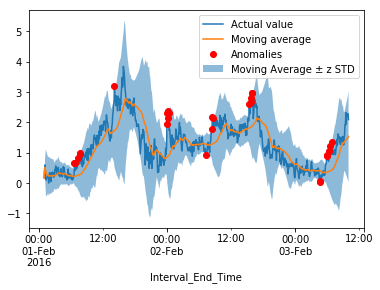

In [7]:
_, ax = plt.subplots() # initialize plot

# Define the boundary for what is considered an anomaly
pewm['Mean_plus_zStd'] = pewm.Mean.add(pewm.Std.mul(z))
pewm['Mean_minus_zStd'] = pewm.Mean.sub(pewm.Std.mul(z))

# Identify anomalies
anomalies = df[(df[value_col] > pewm['Mean_plus_zStd']) | (df[value_col] < pewm['Mean_minus_zStd'])]

df.plot(y = value_col, ax = ax) # plot raw data
pewm.plot(y = 'Mean', ax = ax) # plot moving average
if not anomalies.empty:
    anomalies.plot(y = value_col, ax = ax, style=['ro']) # plot anomalies as red dots
ax.fill_between(df.index, pewm.Mean_plus_zStd, pewm.Mean_minus_zStd, alpha=0.5) # fill the regions showing boundary for anomalies
ax.legend(['Actual value', 'Moving average', 'Moving Average + z STD', 'Moving Average - z STD']);
if not anomalies.empty:
    ax.legend(['Actual value', 'Moving average', 'Anomalies', 'Moving Average �� z STD']);
else:
    ax.legend(['Actual value', 'Moving average', 'Moving Average �� z STD']);

With our sample wind speed data set, we can see from the plot that our PEWMA model has a good track record of finding the leading edge of steeper than usual increases in wind speed. 

<div style="height:60px;"><div style="height:7px;background-color:#20B3CD;width:100%;margin-top:20px;position:relative;"><img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="height:50px;width:50px;margin-top:-20px;position:absolute;margin-left:42%;"></div></div>